# Hierarchical Dispatch

This notebook illustrates an example of how to use Osier's `LogicDispatchModel`.

In [30]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from unyt import MW, GW, km, unyt_array

# osier imports
from osier import LogicDispatchModel, DispatchModel
from osier.tech_library import nuclear_adv, wind, battery, natural_gas
from osier import total_cost, annual_emission

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.pcp import PCP

In [2]:
N=24
demand = np.ones(N)*100
wind_speed = np.random.weibull(a=2.5,size=N)

In [63]:
battery.storage_capacity

unyt_quantity(400., 'MW*hr')

In [94]:
nuclear_adv.capacity = 50
wind.capacity = 100
battery.capacity = 100

natural_gas.capacity = 0.1

In [98]:
nuclear_adv.reset_history()

In [99]:
nuclear_adv.power_level

unyt_quantity(50., 'MW')

In [100]:
nuclear_adv.power_output(demand=-1*MW)

unyt_quantity(37.5, 'MW')

In [101]:
battery.initial_storage = 100

In [103]:
natural_gas.power_output(-1*MW)

unyt_quantity(0., 'MW')

In [83]:
tech_list = [nuclear_adv, wind, battery, natural_gas]
tech_list

[Nuclear_Adv: 0.1 MW,
 WindTurbine: 100.0 MW,
 Battery: 100.0 MW,
 NaturalGas_Conv: 0.1 MW]

In [84]:
net_demand = demand - wind_speed*wind.capacity.to_value()
net_demand

array([  -8.16983792,   36.85017355,   43.50402908,   -6.16971374,
        -17.70082279,   22.60276088,   29.33647965,   54.57836447,
         19.13062058,  -14.67531027,   90.43536173,   41.79955077,
         64.93959926,   14.77231421, -119.94658745,    8.7680144 ,
         -0.64335546,  -13.80072492,   58.1319253 ,   76.24943415,
        -32.13105368,   40.13156249,   40.07400895,  -10.76656657])

In [85]:
model = LogicDispatchModel(technology_list=[t for t in tech_list if t.dispatchable],
                           net_demand=net_demand)

In [86]:
%%timeit
model.solve()

19.3 ms ± 275 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
model.solve()

unyt_array([ -16.33967584,    0.        ,    0.        ,  -12.33942748,
        -35.40164557,    0.        ,    0.        ,   53.83143317,
         18.93062058,  -29.35062054,   75.56005146,   41.59955077,
         64.73959926,   14.57231421, -219.94658745,    0.        ,
         -1.28671093,  -27.60144983,    0.        ,   28.10529347,
        -64.26210735,    7.80050881,   39.87400895,  -21.53313314], 'MW')

In [15]:
model.results

In [88]:
for t in model.technology_list:
    print(t.power_history)

[unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW'), unyt_quantity(0.1, 'MW')]
[unyt_quantity(-8.16983792, 'MW'), unyt_quantity(36.65017355, 'MW'), unyt_quantity(43.30402908, 'MW'), unyt_quantity(-6.16971374, 'MW'), unyt_quantity(-17.70082279, 'MW'), unyt_quantity(22.40276088, 'MW'), unyt_quantity(29.13647965, 'MW'), unyt_quantity(0.54693129, 'MWh/hr'), unyt_quantity(0., 'MWh/hr'), unyt_quantity(-14.67531027, 'MW'), unyt_quantity(14.67531027, 'MWh/hr'), unyt_quantity(0., 'MWh/hr'), unyt_quantity(0., 'MWh/hr'), unyt_quantity(0., 'MWh/hr'), unyt_quantity(-100., 'MW'), unyt_quantity(8.5680144, 'MW'), unyt_quantity(-0.64335546, 'MW'), unyt_quantity(-13.80072492, 'MW'), unyt_quantity(

In [89]:
print(model.technology_list)

[Nuclear_Adv: 0.1 MW, Battery: 100.0 MW, NaturalGas_Conv: 0.1 MW]


In [90]:
data = {}
for t in model.technology_list:
    if t.technology_type == 'storage':
        if len(t.power_history) == 0:
            data[f"{t.technology_name}_charge"] = np.zeros(len(model.net_demand))
        else:
            data[f"{t.technology_name}_charge"] = unyt_array(t.power_history).to_ndarray()
        if len(t.storage_history) == 0:
            data[f"{t.technology_name}_level"] = np.zeros(len(model.net_demand))
        else:
            data[f"{t.technology_name}_level"] = unyt_array(t.storage_history).to_ndarray()
    else:
        if len(t.power_history) == 0:
            data[t.technology_name] = np.zeros(len(model.net_demand))
        else:
            data[t.technology_name] = unyt_array(t.power_history).to_ndarray()
# results = pd.DataFrame(data)

In [91]:
model.technology_list[0].

SyntaxError: invalid syntax (519241152.py, line 1)

In [75]:
data

{'Nuclear_Adv': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Battery_charge': array([  -8.16983792,   36.85017355,   43.50402908,   -6.16971374,
         -17.70082279,   22.60276088,   29.08341095,    0.        ,
           0.        ,  -14.67531027,   14.67531027,    0.        ,
           0.        ,    0.        , -100.        ,    8.7680144 ,
          -0.64335546,  -13.80072492,   58.1319253 ,   47.54414068,
         -32.13105368,   32.13105368,    0.        ,  -10.76656657]),
 'Battery_level': array([108.16983792,  71.31966438,  27.8156353 ,  33.98534904,
         51.68617183,  29.08341095,   0.        ,   0.        ,
          0.        ,  14.67531027,   0.        ,   0.        ,
          0.        ,   0.        , 100.        ,  91.2319856 ,
         91.87534107, 105.67606598,  47.54414068,   0.        ,
         32.13105368,   0.        ,   0.        ,  10.76656657]),
 'NaturalGas_Conv': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [93]:
for k,v in data.items():
    print(k)
    print(len(v))

Nuclear_Adv
15
Battery_charge
24
Battery_level
24
NaturalGas_Conv
15


In [92]:
pd.DataFrame(data)

ValueError: All arrays must be of the same length

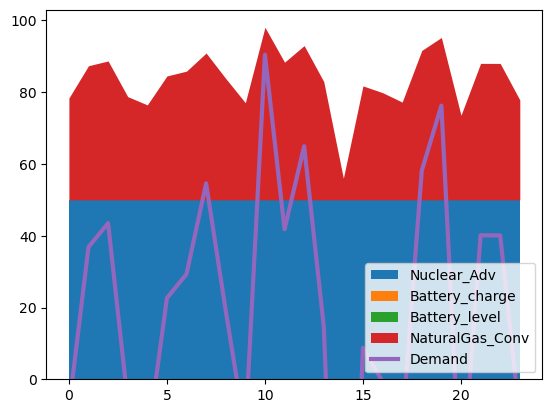

In [73]:
ax = results.plot.area(linewidth=0)
ax.plot(model.net_demand, lw=3, label='Demand')
ax.legend()

In [31]:
original_model = DispatchModel(technology_list=[t for t in tech_list if t.dispatchable],
                           net_demand=net_demand)

In [36]:
%%timeit
original_model.solve()

80.6 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<Axes: >

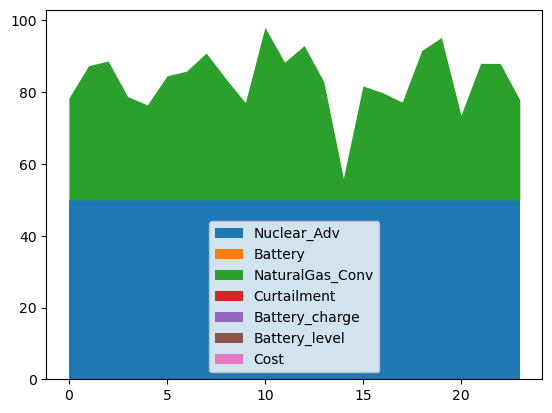

In [35]:
original_model.results.plot.area(lw=0)

In [45]:
from timeit import timeit, repeat

In [41]:
logic_time = timeit(stmt="model.solve()",
                    globals=globals(),
                    number=7)

In [46]:
logic_time = repeat(stmt="model.solve()",
                    globals=globals(),
                    repeat=7,
                    number=10)

In [54]:
(np.array(logic_time)/10*1e3).std()

np.float64(3.4105235536040897)